#  Adversarial training


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join

import time 
import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import gc


from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import Loss,CategoricalCrossentropy

import copy

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report


from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images


gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

In [3]:
tf.config.run_functions_eagerly(False)

In [4]:
tf.random.set_seed(0)

#### 1. Load Data

In [5]:
data_mnist=datasets.mnist.load_data(path='mnist.npz')
X_train_mnist,y_train_mnist=data_mnist[0][0],data_mnist[0][1]
X_test_mnist,y_test_mnist=data_mnist[1][0],data_mnist[1][1]
y_train= to_categorical(y_train_mnist, 10)
y_test= to_categorical(y_test_mnist, 10)

""" Train """
X_train_img_mnist = np.full((60000, 32, 32, 3), 0)
for i, s in enumerate(X_train_mnist):
    X_train_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB)
    
    
    
""" Test """
X_test_img_mnist = np.full((10000, 32, 32, 3), 0)
for i, s in enumerate(X_test_mnist):
    X_test_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB)
    
X_train=X_train_img_mnist
X_test= X_test_img_mnist

In [6]:
data_set=tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(buffer_size=100000).batch(32)

#### 2. Load models

On défini une classe qui créé des modèles dont la fonction objectif est une combinaison de deux fonction objectifs. La première est une cross-entropie classique et la seconde est une cross-entropie adverse. C'est à dire une fonction qui vise à correctement classifier un exemple adverse 

$$J_{tot}(\theta,x,y)=(1-c)J(\theta,x,y)+cJ(\theta,(x+{\epsilon}sign(\nabla_{x}J(\theta,x,y)),y)$$ 

Pour cela nous avons du réécrire la fonction d'entrainement du modèle afin d'entrainer la bonne fonction objectif

In [7]:
class Model(tf.keras.Model):
    def __init__(self,c,learning_rate,epsilon):
        super(Model,self).__init__()
        
        self.c=c
        self.learning_rate=learning_rate
        self.epsilon=epsilon
        
        self.model = tf.keras.models.Sequential()
        self.model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(32,32,3)))
        self.model.add(MaxPooling2D(2, 2))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(10, activation='softmax'))

        self.loss = CategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.SGD(self.learning_rate)        
        
   
    @tf.function
    def train_step(self,x,y):

        with tf.GradientTape() as tape_w:  
            
            with tf.GradientTape() as tape_x:
                tape_x.watch(x)
                true_loss = self.loss(y, self.model(x))        
            gradient = tape_x.gradient(true_loss, x)       
            signed_grad = tf.sign(gradient)      
            adv_loss= self.loss(y, self.model(x+self.epsilon*signed_grad))    
       
      # Combines both losses            
            total_loss= (1-self.c)*true_loss + self.c*adv_loss
            
    # Regular backward pass.
            gradients = tape_w.gradient(total_loss, self.model.trainable_variables)        
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            
       
    def train(self,train_dataset, x_test,y_test,epochs):

        pred=list(map(np.argmax,self.model.predict(x_test)))
        true_values=list(map(np.argmax,y_test))
        acc=np.sum([1 for i in range(len(pred)) if pred[i]==true_values[i]])/len(pred)         
        print('Accuracy before training is {} '.format(acc))
        print('-----------')

        for epoch in range(epochs):
            if epoch==8:
                self.epsilon*=10
            start = time.time()
            for (x,y) in tqdm(train_dataset,position=0):
                x=tf.cast(x,dtype='float32')           
                self.train_step(x,y)           

            pred=list(map(np.argmax,self.model.predict(x_test)))
            true_values=list(map(np.argmax,y_test))
            acc=np.sum([1 for i in range(len(pred)) if pred[i]==true_values[i]])/len(pred)         

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
            print('-----------')
            print('Accuracy for epoch {} is {} '.format(epoch + 1, acc))        
            
       
    def call(self, inputs):
        x = self.model(inputs)
        return x


In [8]:
models_dict={}
for c in [0,0.1,0.3,0.5,0.7,0.9]:
    print("======= c: "+str(c)+'======')
    models_dict[c]=Model(c=c,learning_rate=0.001,epsilon=5)
    models_dict[c].train(data_set, X_test[:1000],y_test[:1000], 5)
    

======= c: 0======


  0%|          | 0/1875 [00:00<?, ?it/s]

Accuracy before training is 0.098 
-----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 1 is 10.282973051071167 sec
-----------
Accuracy for epoch 1 is 0.972 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 2 is 9.35373830795288 sec
-----------
Accuracy for epoch 2 is 0.982 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 3 is 9.392571687698364 sec
-----------
Accuracy for epoch 3 is 0.981 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 4 is 9.386652708053589 sec
-----------
Accuracy for epoch 4 is 0.98 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 5 is 9.39187240600586 sec
-----------
Accuracy for epoch 5 is 0.981 
======= c: 0.1======
Accuracy before training is 0.064 
-----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 1 is 9.876091480255127 sec
-----------
Accuracy for epoch 1 is 0.967 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 2 is 9.467870235443115 sec
-----------
Accuracy for epoch 2 is 0.975 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 3 is 9.437579870223999 sec
-----------
Accuracy for epoch 3 is 0.977 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 4 is 9.501304626464844 sec
-----------
Accuracy for epoch 4 is 0.981 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 5 is 9.485798358917236 sec
-----------
Accuracy for epoch 5 is 0.979 
======= c: 0.3======
Accuracy before training is 0.08 
-----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 1 is 9.90507984161377 sec
-----------
Accuracy for epoch 1 is 0.961 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 2 is 9.4884774684906 sec
-----------
Accuracy for epoch 2 is 0.969 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 3 is 9.448281526565552 sec
-----------
Accuracy for epoch 3 is 0.974 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 4 is 9.525576114654541 sec
-----------
Accuracy for epoch 4 is 0.976 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 5 is 9.520234823226929 sec
-----------
Accuracy for epoch 5 is 0.973 
======= c: 0.5======
Accuracy before training is 0.114 
-----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 1 is 9.945320129394531 sec
-----------
Accuracy for epoch 1 is 0.959 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 2 is 9.452945232391357 sec
-----------
Accuracy for epoch 2 is 0.969 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 3 is 9.466622591018677 sec
-----------
Accuracy for epoch 3 is 0.972 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 4 is 9.449608087539673 sec
-----------
Accuracy for epoch 4 is 0.976 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 5 is 9.438313007354736 sec
-----------
Accuracy for epoch 5 is 0.978 
======= c: 0.7======
Accuracy before training is 0.118 
-----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 1 is 9.986953496932983 sec
-----------
Accuracy for epoch 1 is 0.95 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 2 is 9.433323383331299 sec
-----------
Accuracy for epoch 2 is 0.967 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 3 is 9.393277645111084 sec
-----------
Accuracy for epoch 3 is 0.97 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 4 is 9.42918586730957 sec
-----------
Accuracy for epoch 4 is 0.968 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 5 is 9.356329679489136 sec
-----------
Accuracy for epoch 5 is 0.975 
======= c: 0.9======
Accuracy before training is 0.12 
-----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 1 is 9.852025270462036 sec
-----------
Accuracy for epoch 1 is 0.914 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 2 is 9.482837915420532 sec
-----------
Accuracy for epoch 2 is 0.95 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 3 is 9.422252893447876 sec
-----------
Accuracy for epoch 3 is 0.97 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 4 is 9.52458930015564 sec
-----------
Accuracy for epoch 4 is 0.97 


100%|██████████| 1875/1875 [00:09<00:00, 199.73it/s]


Time for epoch 5 is 9.47998595237732 sec
-----------
Accuracy for epoch 5 is 0.972 


In [9]:
def DOC (x_adv_list,x_list):
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

Test de la resistance du modèle 

In [10]:
def attack_performances_computer(model_to_attack,predicting_model,attack, image_list, labels,epsilon):
    model_to_attack=TensorFlowModel(model_to_attack , bounds=(0, 255))
   
    success_on_attacked_model=[]
    success_on_predicting_model=[]
    adv_list=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:
                                  ,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_attack,image,label,epsilons=[epsilon])
        success_on_attacked_model.append(bool(is_adv[0]))
        adv_list.append(np.array(clipped[0]))
        prediction=predicting_model.predict(np.expand_dims(clipped[0][0],axis=0))
        if np.argmax(prediction)!=labels[i]:
            success_on_predicting_model.append(True)
        else:
            success_on_predicting_model.append(False)
            
        
    DOC_attack=DOC(adv_list,image_list)
    SR_on_attacked_model=succes_rate(success_on_attacked_model)
    SR_on_predicting_model=succes_rate(success_on_predicting_model)
    return(DOC_attack,SR_on_attacked_model,SR_on_predicting_model)


In [11]:
def attack_runner(model_to_attack,predicting_model,image_list, labels_list, epislons_list):   
    labels_list=list(map(np.argmax,labels_list))
    
    attack_FGSM=LinfFastGradientAttack()
    
   

    SR_FGSM_dic={}  
    SR_FGSM_dic_with_defense={}


    for epsilon in epislons_list:
        print('======'+'epislon: '+str(epsilon)+'======')
        DOC_FGSM,SR_FGSM,SR_FGSM_with_defense=attack_performances_computer(model_to_attack,predicting_model,attack_FGSM, image_list, labels_list,epsilon)
              
        SR_FGSM_dic[DOC_FGSM]=SR_FGSM
        SR_FGSM_dic_with_defense[DOC_FGSM]=SR_FGSM_with_defense
        
    return(SR_FGSM_dic,SR_FGSM_dic_with_defense)

In [12]:
plots={}
epsilons=[0.1,0.5,1,5,7,10,15,20,30,50]
X=X_test[7000:7100]
y=y_test[7000:7100]
for c,model in models_dict.items():
    print("======= c: "+str(c)+'======')
    plots[c],_=attack_runner(model,model,X, y, epsilons)
    

======= c: 0======
======epislon: 0.1======
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


  4%|▍         | 4/100 [00:00<00:03, 30.87it/s]

======epislon: 0.5======


  4%|▍         | 4/100 [00:00<00:03, 29.85it/s]

======epislon: 1======


  3%|▎         | 3/100 [00:00<00:03, 29.52it/s]

======epislon: 5======


  3%|▎         | 3/100 [00:00<00:03, 29.99it/s]

======epislon: 7======


  3%|▎         | 3/100 [00:00<00:03, 29.00it/s]

======epislon: 10======


  3%|▎         | 3/100 [00:00<00:03, 26.42it/s]

======epislon: 15======


  3%|▎         | 3/100 [00:00<00:03, 29.96it/s]

======epislon: 20======


  4%|▍         | 4/100 [00:00<00:03, 30.38it/s]

======epislon: 30======


  3%|▎         | 3/100 [00:00<00:03, 29.54it/s]

======epislon: 50======


  3%|▎         | 3/100 [00:00<00:04, 23.91it/s]

======= c: 0.1======
======epislon: 0.1======


  3%|▎         | 3/100 [00:00<00:03, 29.18it/s]

======epislon: 0.5======


  3%|▎         | 3/100 [00:00<00:03, 29.58it/s]

======epislon: 1======


  3%|▎         | 3/100 [00:00<00:03, 29.75it/s]

======epislon: 5======


  3%|▎         | 3/100 [00:00<00:03, 29.79it/s]

======epislon: 7======


  4%|▍         | 4/100 [00:00<00:02, 32.47it/s]

======epislon: 10======


  3%|▎         | 3/100 [00:00<00:03, 29.86it/s]

======epislon: 15======


  3%|▎         | 3/100 [00:00<00:03, 27.82it/s]

======epislon: 20======


  4%|▍         | 4/100 [00:00<00:03, 30.86it/s]

======epislon: 30======


  4%|▍         | 4/100 [00:00<00:03, 30.82it/s]

======epislon: 50======


  2%|▏         | 2/100 [00:00<00:04, 19.99it/s]

======= c: 0.3======
======epislon: 0.1======


  3%|▎         | 3/100 [00:00<00:03, 28.69it/s]

======epislon: 0.5======


  3%|▎         | 3/100 [00:00<00:03, 29.18it/s]

======epislon: 1======


  3%|▎         | 3/100 [00:00<00:03, 29.78it/s]

======epislon: 5======


  3%|▎         | 3/100 [00:00<00:03, 29.94it/s]

======epislon: 7======


  3%|▎         | 3/100 [00:00<00:03, 27.28it/s]

======epislon: 10======


  4%|▍         | 4/100 [00:00<00:03, 30.48it/s]

======epislon: 15======


  3%|▎         | 3/100 [00:00<00:03, 27.42it/s]

======epislon: 20======


  4%|▍         | 4/100 [00:00<00:02, 32.01it/s]

======epislon: 30======


  4%|▍         | 4/100 [00:00<00:03, 31.06it/s]

======epislon: 50======


  3%|▎         | 3/100 [00:00<00:03, 24.57it/s]

======= c: 0.5======
======epislon: 0.1======


  4%|▍         | 4/100 [00:00<00:03, 31.01it/s]

======epislon: 0.5======


  4%|▍         | 4/100 [00:00<00:03, 30.96it/s]

======epislon: 1======


  4%|▍         | 4/100 [00:00<00:02, 32.03it/s]

======epislon: 5======


  4%|▍         | 4/100 [00:00<00:02, 32.71it/s]

======epislon: 7======


  4%|▍         | 4/100 [00:00<00:03, 30.72it/s]

======epislon: 10======


  4%|▍         | 4/100 [00:00<00:03, 30.77it/s]

======epislon: 15======


  4%|▍         | 4/100 [00:00<00:03, 31.63it/s]

======epislon: 20======


  4%|▍         | 4/100 [00:00<00:03, 30.55it/s]

======epislon: 30======


  4%|▍         | 4/100 [00:00<00:03, 30.55it/s]

======epislon: 50======


  3%|▎         | 3/100 [00:00<00:04, 23.16it/s]

======= c: 0.7======
======epislon: 0.1======


  4%|▍         | 4/100 [00:00<00:03, 31.18it/s]

======epislon: 0.5======


  4%|▍         | 4/100 [00:00<00:02, 32.60it/s]

======epislon: 1======


  4%|▍         | 4/100 [00:00<00:02, 32.28it/s]

======epislon: 5======


  4%|▍         | 4/100 [00:00<00:02, 32.50it/s]

======epislon: 7======


  3%|▎         | 3/100 [00:00<00:03, 29.19it/s]

======epislon: 10======


  3%|▎         | 3/100 [00:00<00:03, 29.02it/s]

======epislon: 15======


  4%|▍         | 4/100 [00:00<00:03, 30.52it/s]

======epislon: 20======


  4%|▍         | 4/100 [00:00<00:03, 30.72it/s]

======epislon: 30======


  4%|▍         | 4/100 [00:00<00:03, 30.99it/s]

======epislon: 50======


  3%|▎         | 3/100 [00:00<00:04, 24.20it/s]

======= c: 0.9======
======epislon: 0.1======


  4%|▍         | 4/100 [00:00<00:03, 31.33it/s]

======epislon: 0.5======


  4%|▍         | 4/100 [00:00<00:02, 32.62it/s]

======epislon: 1======


  3%|▎         | 3/100 [00:00<00:03, 27.35it/s]

======epislon: 5======


  4%|▍         | 4/100 [00:00<00:03, 30.90it/s]

======epislon: 7======


  4%|▍         | 4/100 [00:00<00:03, 30.22it/s]

======epislon: 10======


  4%|▍         | 4/100 [00:00<00:03, 30.51it/s]

======epislon: 15======


  4%|▍         | 4/100 [00:00<00:03, 31.19it/s]

======epislon: 20======


  4%|▍         | 4/100 [00:00<00:03, 31.25it/s]

======epislon: 30======


  4%|▍         | 4/100 [00:00<00:03, 31.13it/s]

======epislon: 50======


100%|██████████| 100/100 [00:03<00:00, 28.58it/s]


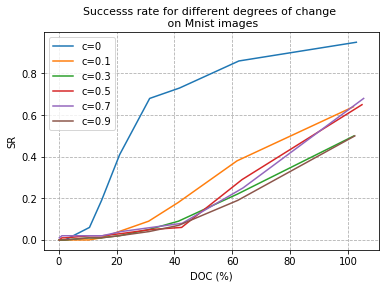

In [13]:
for c,plot in plots.items():
    plt.plot(list(plot.keys()),list(plot.values()),label='c='+str(c))
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change \n on Mnist images',fontsize=11)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='upper left')

Clearly the adversarial training has decreased the efficiency of the attacks so it is truly beneficial. It seems that the higher c is and the better the protection

Let's save the 'best model' --> c=0.9

In [ ]:
models_dict[0.9].save('/media/hdd1/benchmark_adversarial_attacks/model_adv_training.h5')

### Softmax probabilities visualizations

At first let's create some adversarial examples that will fool the most basic model

In [14]:
model_naif=models_dict[0]
model_to_attack=TensorFlowModel(model_naif , bounds=(0, 255))
attack=LinfFastGradientAttack()
image_list=X_test[:100]
labels=list(map(np.argmax,y_test[:100]))
adv_list=[]
true_label=[]
for i,image in enumerate(tqdm(image_list,position=0)):
    image = np.asarray(image)[:,:,:3].astype('float32')
    image = convert_to_tensor(np.expand_dims(image,axis=0))
    label=labels[i]
    label = tf.convert_to_tensor(np.array([label]))
    _, clipped, is_adv = attack(model_to_attack,image,label,epsilons=50)
    if bool(is_adv[0])==True:
        adv_list.append(np.array(clipped[0]))
        true_label.append(labels[i])
    

100%|██████████| 100/100 [00:00<00:00, 177.54it/s]


Let's visualize the outputs of the softmax layers of the different models when given the adversarial images 

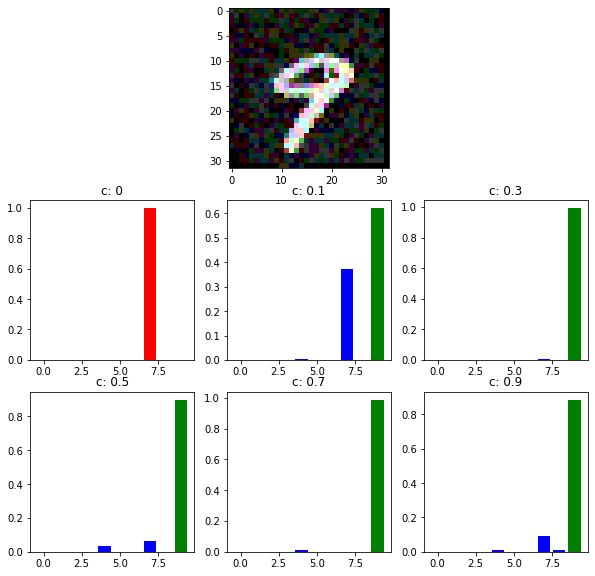

In [15]:
adv_image_num=9


plt.figure(figsize=(10,10))
ax = plt.subplot(3, 3, 2)
plt.imshow(adv_list[adv_image_num].astype('int32'))
for i,c in enumerate([0,0.1,0.3,0.5,0.7,0.9]): 
    ax = plt.subplot(3, 3, 3+i + 1)
    color=['blue' for i in range(10)]
    prediction=models_dict[c].predict(np.expand_dims(adv_list[adv_image_num],axis=0))[0]
    if np.argmax(prediction)==true_label[adv_image_num]:
        color[true_label[adv_image_num]]='green'
    else:
        color[np.argmax(prediction)]='red'
    plt.bar(x=[i for i in range(10)], height=prediction,color=color)
    plt.title('c: '+str(c))


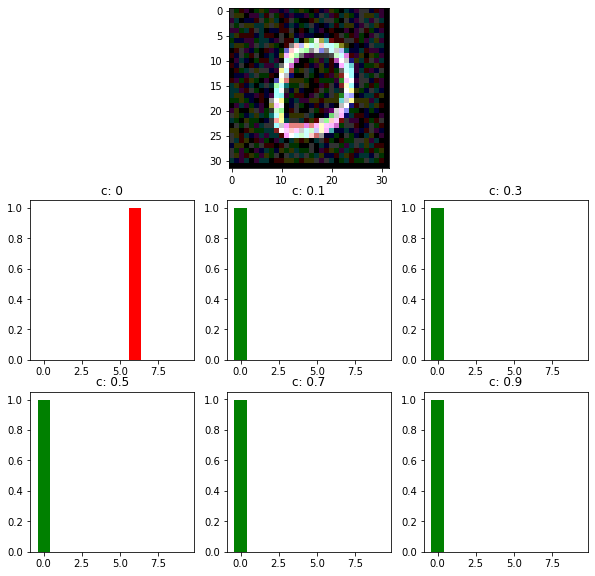

In [16]:
adv_image_num=10


plt.figure(figsize=(10,10))
ax = plt.subplot(3, 3, 2)
plt.imshow(adv_list[adv_image_num].astype('int32'))
for i,c in enumerate([0,0.1,0.3,0.5,0.7,0.9]): 
    ax = plt.subplot(3, 3, 3+i + 1)
    color=['blue' for i in range(10)]
    prediction=models_dict[c].predict(np.expand_dims(adv_list[adv_image_num],axis=0))[0]
    if np.argmax(prediction)==true_label[adv_image_num]:
        color[true_label[adv_image_num]]='green'
    else:
        color[np.argmax(prediction)]='red'
    plt.bar(x=[i for i in range(10)], height=prediction,color=color)
    plt.title('c: '+str(c))

### Against a black box attack (boundary attack)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 350.43it/s]

Adversarial image at step 0. L2 error 7927.612941573333 and class label 5.


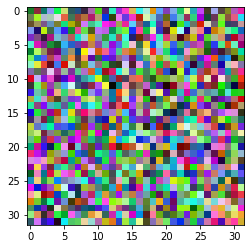

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


Adversarial image at step 1. L2 error 7848.504787000223 and class label 5.


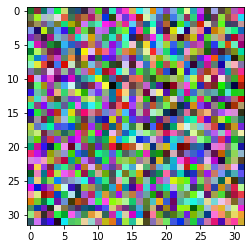

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s]


Adversarial image at step 2. L2 error 7730.885988976645 and class label 5.


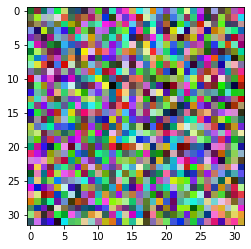

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]


Adversarial image at step 3. L2 error 7557.0381972689365 and class label 5.


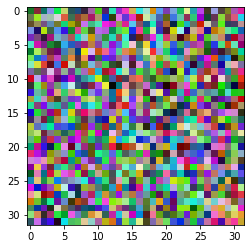

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.08it/s]


Adversarial image at step 4. L2 error 7302.27080199194 and class label 5.


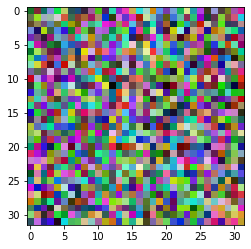

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]


Adversarial image at step 5. L2 error 6933.252956596057 and class label 5.


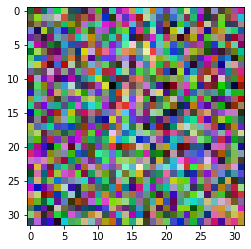

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.05it/s]


Adversarial image at step 6. L2 error 6407.856135985892 and class label 5.


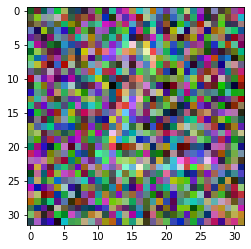

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


Adversarial image at step 7. L2 error 5679.3559832792225 and class label 5.


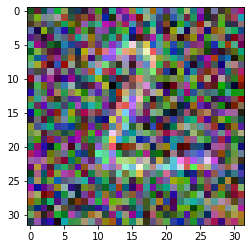

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


Adversarial image at step 8. L2 error 4710.759770952699 and class label 5.


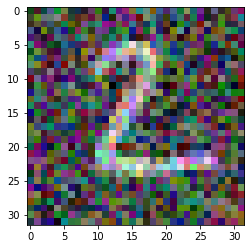

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


Adversarial image at step 9. L2 error 4472.630867497066 and class label 5.


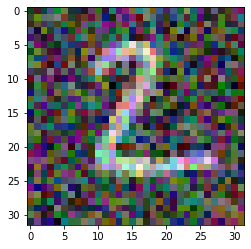

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Adversarial image at step 10. L2 error 4321.256126349275 and class label 5.


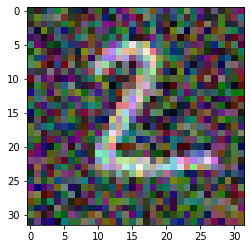

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Adversarial image at step 11. L2 error 4176.408288015616 and class label 5.


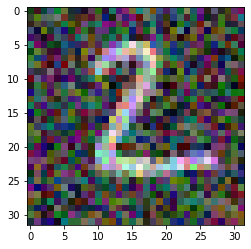

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


Adversarial image at step 12. L2 error 4081.2519889430023 and class label 5.


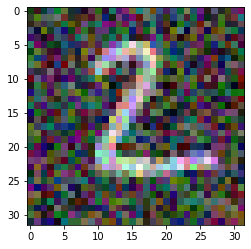

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.15it/s]


Adversarial image at step 13. L2 error 3987.9423712333105 and class label 5.


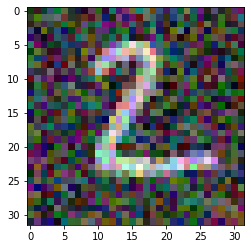

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.17it/s]


Adversarial image at step 14. L2 error 3891.184174565994 and class label 5.


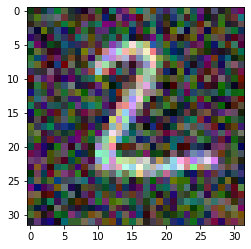

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.60it/s]


Adversarial image at step 15. L2 error 3802.974032422494 and class label 5.


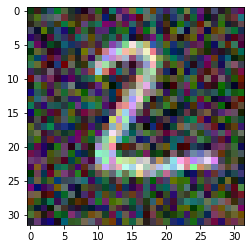

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Adversarial image at step 16. L2 error 3718.8343995889304 and class label 5.


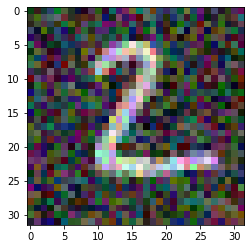

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.63it/s]


Adversarial image at step 17. L2 error 3638.9033419954885 and class label 5.


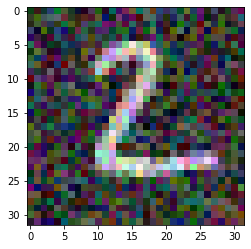

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


Adversarial image at step 18. L2 error 3557.6165551518297 and class label 5.


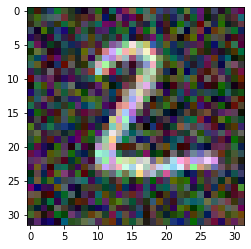

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


Adversarial image at step 19. L2 error 3430.1873217124617 and class label 5.


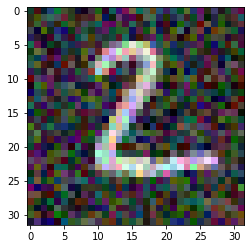

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.17it/s]

Adversarial image at step 20. L2 error 3257.557423745276 and class label 5.


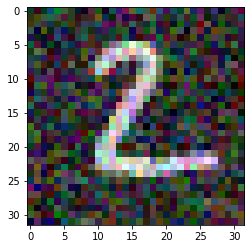

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.51it/s]


Adversarial image at step 21. L2 error 3128.388803212134 and class label 5.


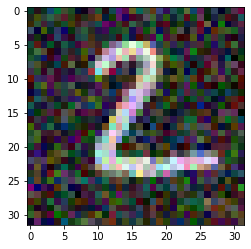

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.54it/s]


Adversarial image at step 22. L2 error 3064.7138196497804 and class label 5.


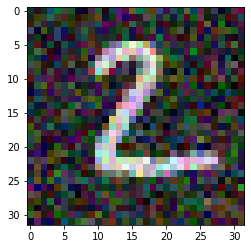

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.82it/s]


Adversarial image at step 23. L2 error 2996.40741137135 and class label 5.


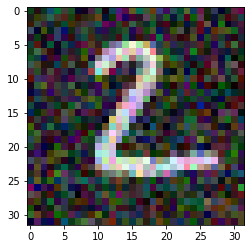

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]


Adversarial image at step 24. L2 error 2921.515973147286 and class label 5.


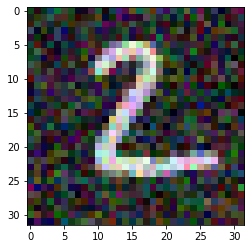

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


Adversarial image at step 25. L2 error 2854.0049935542065 and class label 5.


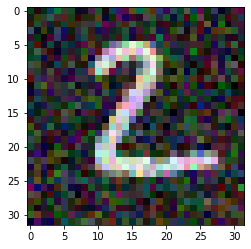

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.95it/s]


Adversarial image at step 26. L2 error 2791.5435014016925 and class label 5.


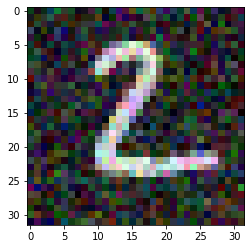

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.64it/s]


Adversarial image at step 27. L2 error 2748.5683354116304 and class label 5.


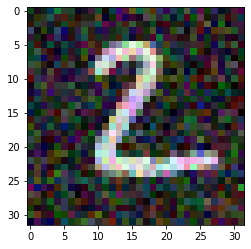

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 25.99it/s]


Adversarial image at step 28. L2 error 2704.8588532293593 and class label 5.


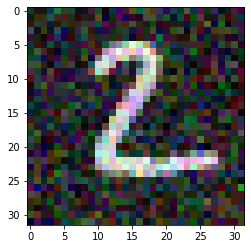

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s]


Adversarial image at step 29. L2 error 2668.286276145595 and class label 5.


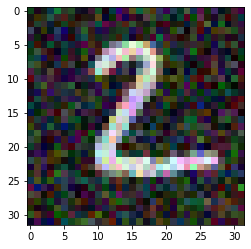

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.17it/s]


Adversarial image at step 30. L2 error 2634.5378068569635 and class label 5.


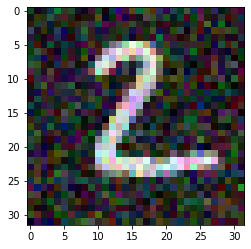

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 25.73it/s]


Adversarial image at step 31. L2 error 2596.6585938222233 and class label 5.


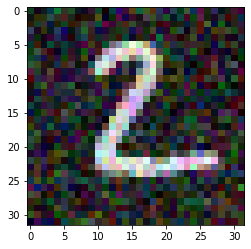

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 25.22it/s]


Adversarial image at step 32. L2 error 2560.7044918037773 and class label 5.


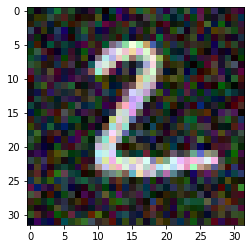

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


Adversarial image at step 33. L2 error 2547.5133173917056 and class label 5.


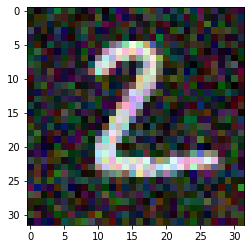

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s]


Adversarial image at step 34. L2 error 2529.7514373586373 and class label 5.


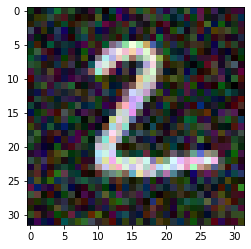

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Adversarial image at step 35. L2 error 2503.4946531482638 and class label 5.


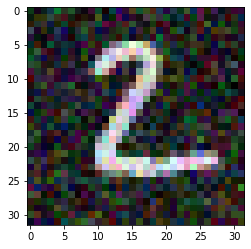

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s]


Adversarial image at step 36. L2 error 2479.747052139818 and class label 5.


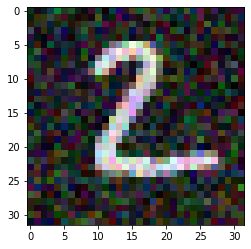

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s]


Adversarial image at step 37. L2 error 2458.529265935179 and class label 5.


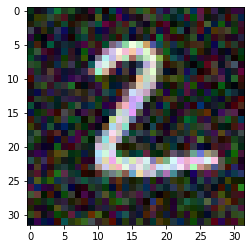

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Adversarial image at step 38. L2 error 2434.6976196613377 and class label 5.


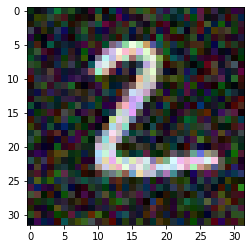

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.98it/s]


Adversarial image at step 39. L2 error 2393.384468106496 and class label 5.


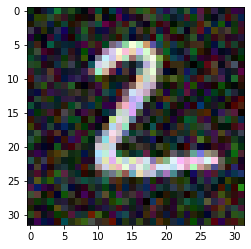

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.21it/s]


Adversarial image at step 40. L2 error 2332.513291868048 and class label 5.


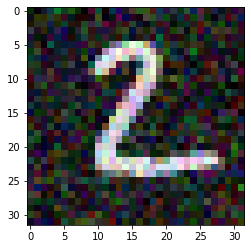

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.50it/s]


Adversarial image at step 41. L2 error 2266.2542970529066 and class label 5.


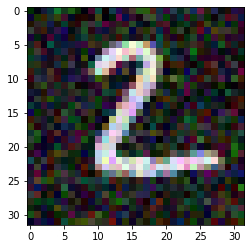

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 26.98it/s]


Adversarial image at step 42. L2 error 2196.6256436435174 and class label 5.


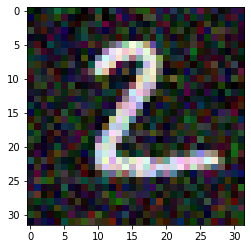

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


Adversarial image at step 43. L2 error 2118.0995732676997 and class label 5.


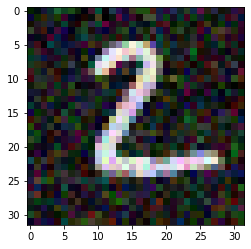

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 27.82it/s]


Adversarial image at step 44. L2 error 2076.331863793885 and class label 5.


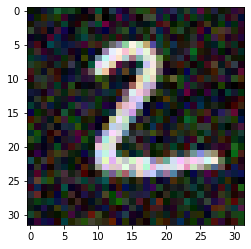

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 25.96it/s]


Adversarial image at step 45. L2 error 2044.253235769386 and class label 5.


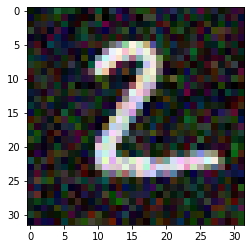

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.94it/s]


Adversarial image at step 46. L2 error 2013.3612118192102 and class label 5.


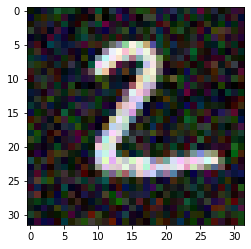

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]


Adversarial image at step 47. L2 error 1984.284525674572 and class label 5.


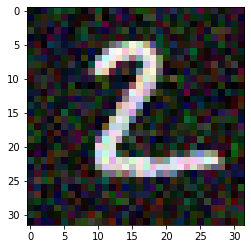

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


Adversarial image at step 48. L2 error 1938.1421469551044 and class label 5.


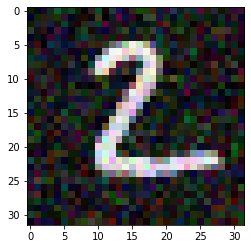

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.98it/s]


Adversarial image at step 49. L2 error 1898.6247784546115 and class label 5.


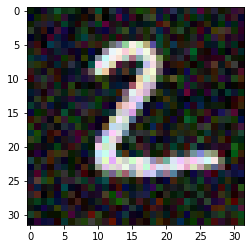

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.45it/s]


Adversarial image at step 50. L2 error 1851.5512642561218 and class label 5.


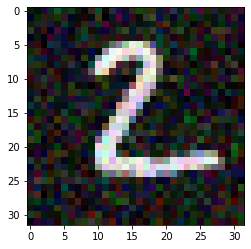

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.08it/s]


Adversarial image at step 51. L2 error 1835.7944061726137 and class label 5.


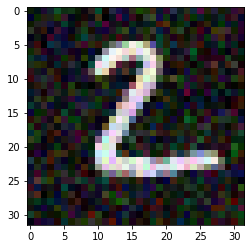

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.76it/s]


Adversarial image at step 52. L2 error 1816.9620883577204 and class label 5.


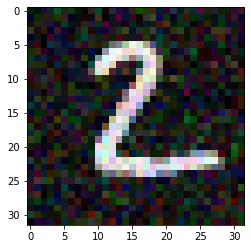

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Adversarial image at step 53. L2 error 1816.9586128642109 and class label 5.


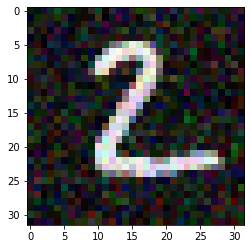

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


Adversarial image at step 54. L2 error 1815.3730821600193 and class label 5.


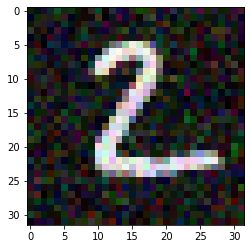

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s]


Adversarial image at step 55. L2 error 1813.4043826685258 and class label 5.


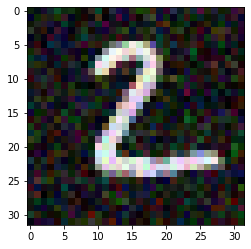

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


Adversarial image at step 56. L2 error 1809.6354537956204 and class label 5.


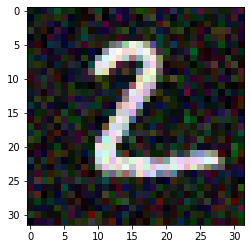

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.87it/s]


Adversarial image at step 57. L2 error 1805.4069019440176 and class label 5.


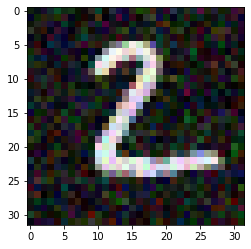

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.24it/s]


Adversarial image at step 58. L2 error 1801.8117027381568 and class label 5.


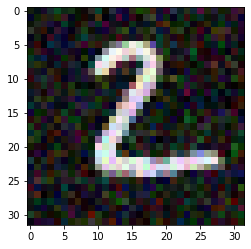

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.94it/s]


Adversarial image at step 59. L2 error 1792.4307553733672 and class label 5.


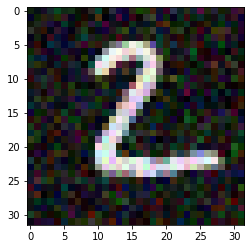

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Adversarial image at step 60. L2 error 1782.7441631172028 and class label 5.


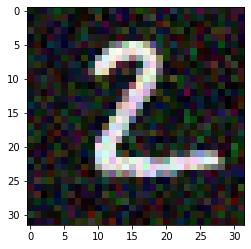

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.92it/s]

Adversarial image at step 61. L2 error 1765.536820488158 and class label 5.


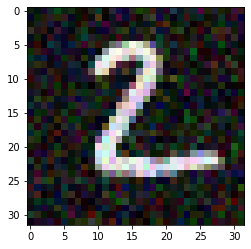

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]


Adversarial image at step 62. L2 error 1742.352491537066 and class label 5.


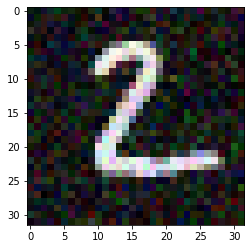

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


Adversarial image at step 63. L2 error 1722.6372670232356 and class label 5.


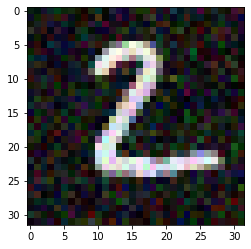

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s]


Adversarial image at step 64. L2 error 1703.60939988271 and class label 5.


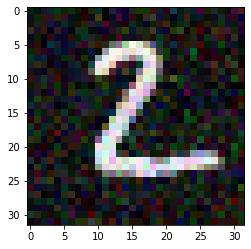

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.50it/s]


Adversarial image at step 65. L2 error 1689.0797384215211 and class label 5.


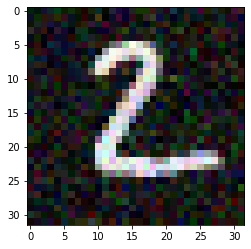

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]


Adversarial image at step 66. L2 error 1673.2095417958799 and class label 5.


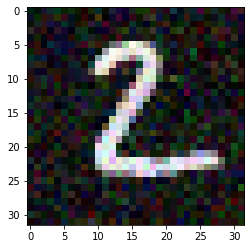

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.75it/s]


Adversarial image at step 67. L2 error 1655.7752742716907 and class label 5.


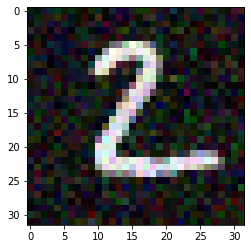

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 25.39it/s]


Adversarial image at step 68. L2 error 1625.671439950531 and class label 5.


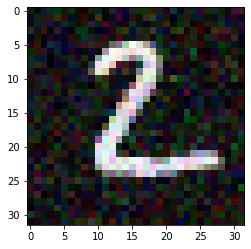

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.17it/s]


Adversarial image at step 69. L2 error 1607.581883222973 and class label 5.


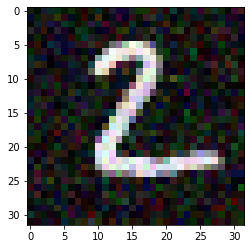

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]


Adversarial image at step 70. L2 error 1581.9573744405195 and class label 5.


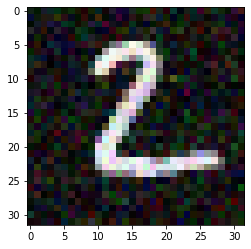

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s]


Adversarial image at step 71. L2 error 1558.266267325599 and class label 5.


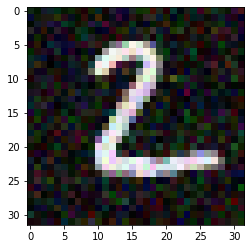

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Adversarial image at step 72. L2 error 1535.7811299493649 and class label 5.


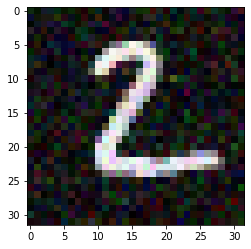

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]


Adversarial image at step 73. L2 error 1517.3677926996668 and class label 5.


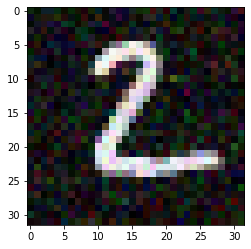

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]


Adversarial image at step 74. L2 error 1507.7187858796729 and class label 5.


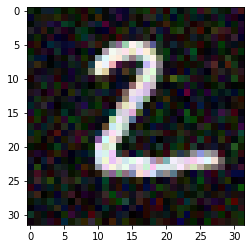

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 26.69it/s]


Adversarial image at step 75. L2 error 1499.8405603127387 and class label 5.


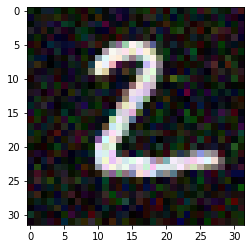

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Adversarial image at step 76. L2 error 1494.0987130423175 and class label 5.


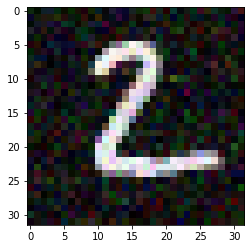

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.76it/s]


Adversarial image at step 77. L2 error 1486.459569966694 and class label 5.


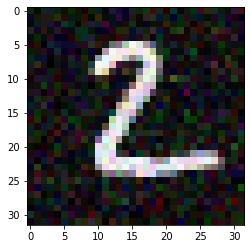

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.29it/s]


Adversarial image at step 78. L2 error 1479.5016216554322 and class label 5.


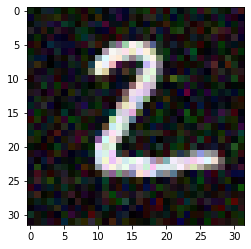

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 25.17it/s]


Adversarial image at step 79. L2 error 1473.1772562116182 and class label 5.


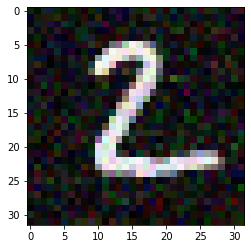

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s]


Adversarial image at step 80. L2 error 1463.173536007765 and class label 5.


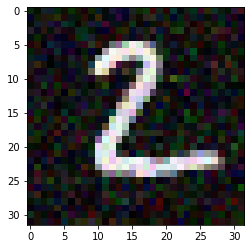

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Adversarial image at step 81. L2 error 1451.8221602749795 and class label 5.


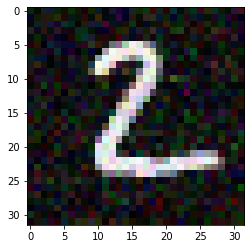

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s]


Adversarial image at step 82. L2 error 1438.877071778723 and class label 5.


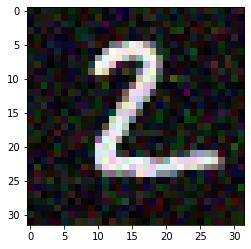

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.70it/s]


Adversarial image at step 83. L2 error 1428.5241721143736 and class label 5.


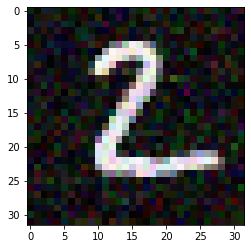

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.13it/s]


Adversarial image at step 84. L2 error 1419.7683553655543 and class label 5.


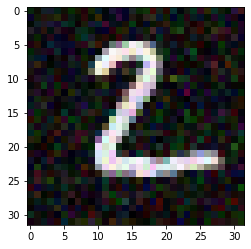

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 26.91it/s]


Adversarial image at step 85. L2 error 1411.8008675860945 and class label 5.


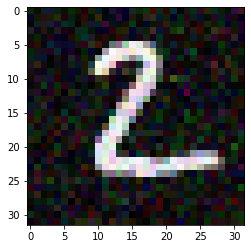

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


Adversarial image at step 86. L2 error 1397.3787033410304 and class label 5.


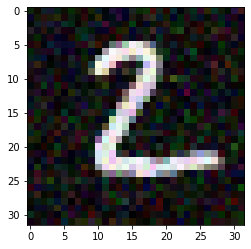

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.87it/s]


Adversarial image at step 87. L2 error 1384.1723356927669 and class label 5.


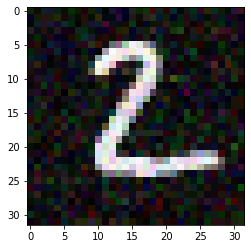

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.82it/s]


Adversarial image at step 88. L2 error 1372.1653531267486 and class label 5.


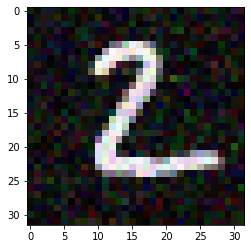

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s]


Adversarial image at step 89. L2 error 1362.6360403299175 and class label 5.


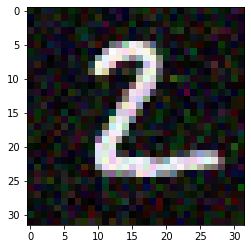

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.58it/s]


Adversarial image at step 90. L2 error 1359.6133674677906 and class label 5.


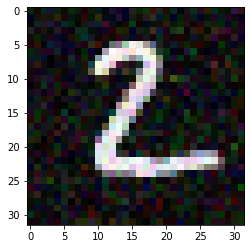

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s]


Adversarial image at step 91. L2 error 1356.4823335181436 and class label 5.


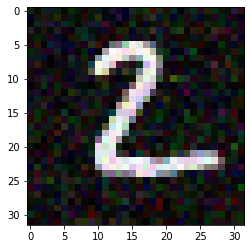

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Adversarial image at step 92. L2 error 1349.438777415266 and class label 5.


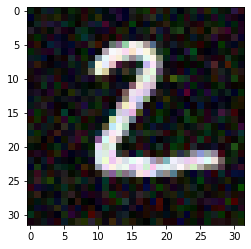

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 26.35it/s]


Adversarial image at step 93. L2 error 1340.2528542794118 and class label 5.


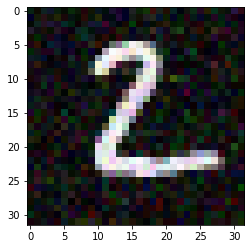

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.92it/s]


Adversarial image at step 94. L2 error 1330.986423183243 and class label 5.


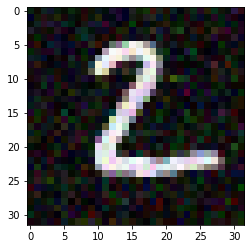

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.96it/s]


Adversarial image at step 95. L2 error 1316.2022826389427 and class label 5.


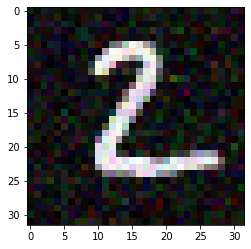

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s]


Adversarial image at step 96. L2 error 1304.0063974272916 and class label 5.


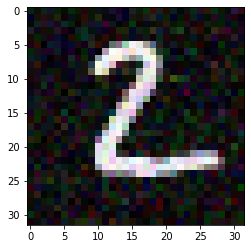

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s]


Adversarial image at step 97. L2 error 1295.0015345650572 and class label 5.


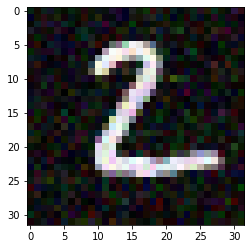

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]


Adversarial image at step 98. L2 error 1290.0790368729308 and class label 5.


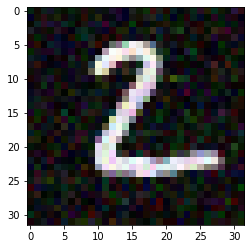

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s]


Adversarial image at step 99. L2 error 1284.3630725864023 and class label 5.


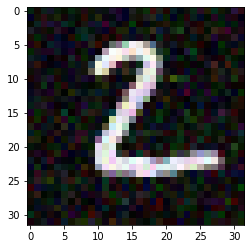

In [17]:
model_without_def=models_dict[0]


classifier = TensorFlowV2Classifier(model=model_without_def, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change_without_def={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.01)
iter_step =1
target=X_test[1]
image_list=[]
x_adv = None
for i in range(100):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype('int32'))
    image_list.append(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change_without_def[i * iter_step]=DOC([x_adv[0]],[target])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 445.97it/s]


Adversarial image at step 0. L2 error 7973.4801865183235 and class label 8.


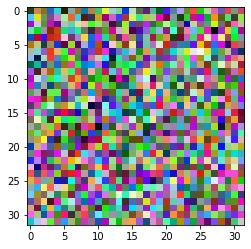

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.60it/s]


Adversarial image at step 1. L2 error 7893.854032332981 and class label 8.


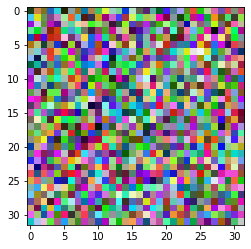

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 14.39it/s]

Adversarial image at step 2. L2 error 7775.6703785044965 and class label 8.


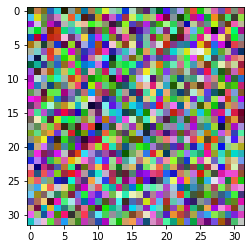

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.76it/s]


Adversarial image at step 3. L2 error 7600.899365950499 and class label 8.


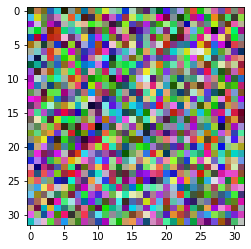

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.14it/s]


Adversarial image at step 4. L2 error 7344.6666067642955 and class label 8.


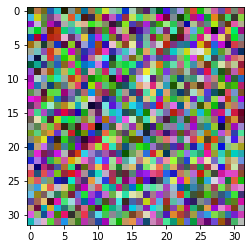

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s]


Adversarial image at step 5. L2 error 6973.9030411080685 and class label 8.


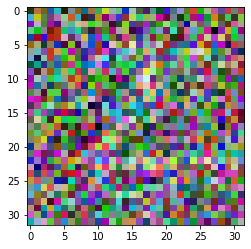

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.16it/s]


Adversarial image at step 6. L2 error 6445.552250800916 and class label 8.


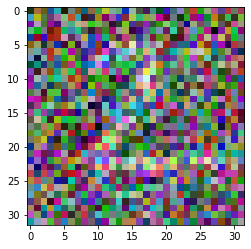

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


Adversarial image at step 7. L2 error 5714.087549827799 and class label 8.


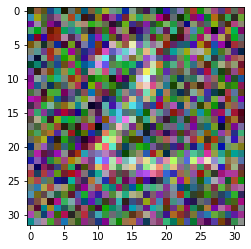

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]


Adversarial image at step 8. L2 error 4739.267811569446 and class label 8.


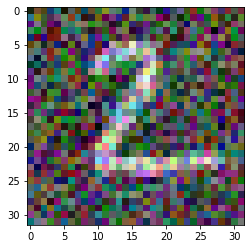

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


Adversarial image at step 9. L2 error 4379.897299567478 and class label 8.


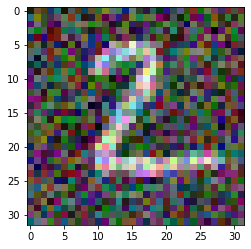

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


Adversarial image at step 10. L2 error 4336.1219245043585 and class label 8.


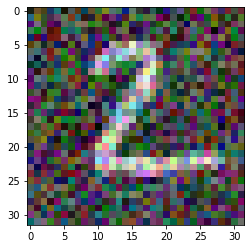

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


Adversarial image at step 11. L2 error 4309.071494512583 and class label 8.


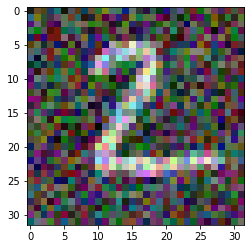

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Adversarial image at step 12. L2 error 4258.543370807029 and class label 8.


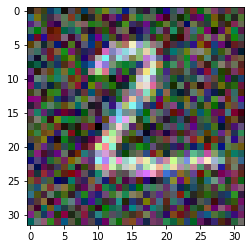

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


Adversarial image at step 13. L2 error 4205.672800090276 and class label 8.


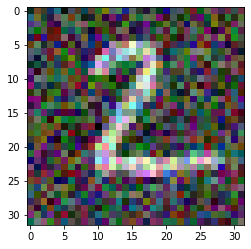

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.12it/s]


Adversarial image at step 14. L2 error 4138.723024408679 and class label 8.


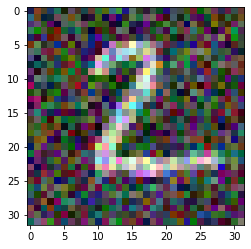

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.48it/s]


Adversarial image at step 15. L2 error 4051.004196931686 and class label 8.


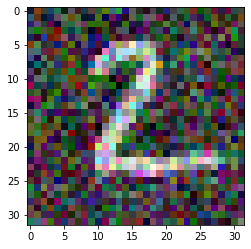

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.51it/s]


Adversarial image at step 16. L2 error 3955.331332573161 and class label 8.


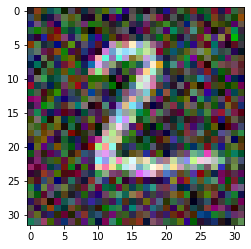

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.44it/s]


Adversarial image at step 17. L2 error 3857.656117559867 and class label 8.


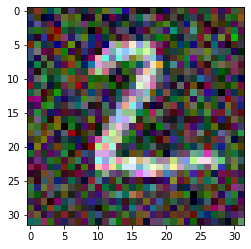

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s]


Adversarial image at step 18. L2 error 3765.726533940162 and class label 8.


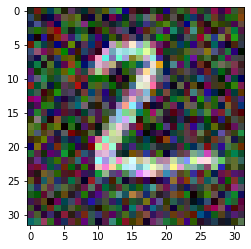

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s]


Adversarial image at step 19. L2 error 3673.8677066846717 and class label 8.


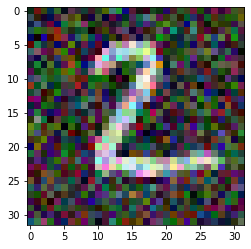

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.24it/s]


Adversarial image at step 20. L2 error 3585.9729083096972 and class label 8.


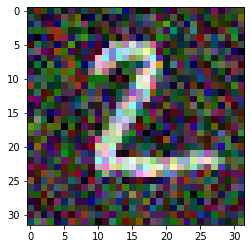

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.95it/s]


Adversarial image at step 21. L2 error 3528.1620152327305 and class label 8.


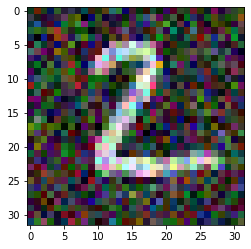

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


Adversarial image at step 22. L2 error 3454.6335813374944 and class label 8.


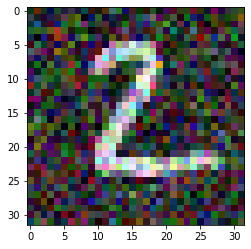

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.85it/s]


Adversarial image at step 23. L2 error 3390.336309151553 and class label 8.


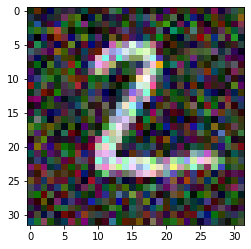

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


Adversarial image at step 24. L2 error 3323.908405724727 and class label 8.


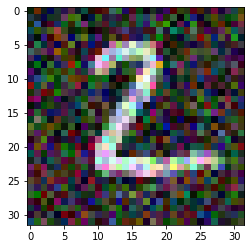

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.77it/s]


Adversarial image at step 25. L2 error 3263.1434096700987 and class label 8.


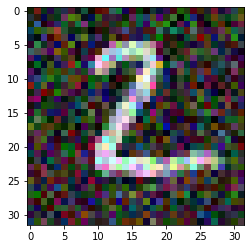

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]


Adversarial image at step 26. L2 error 3175.436647831417 and class label 8.


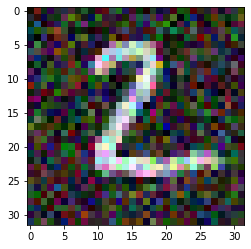

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


Adversarial image at step 27. L2 error 3058.5717016387957 and class label 8.


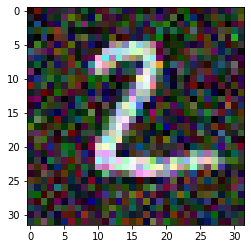

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.50it/s]


Adversarial image at step 28. L2 error 2977.9499755126385 and class label 8.


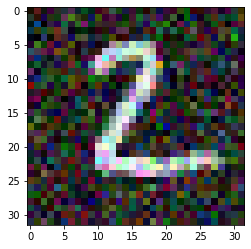

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 26.45it/s]


Adversarial image at step 29. L2 error 2941.0263701444887 and class label 8.


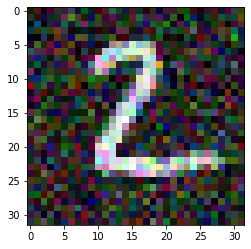

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Adversarial image at step 30. L2 error 2921.1121300313284 and class label 8.


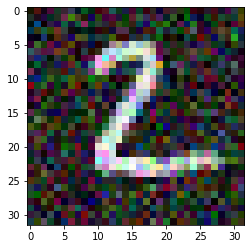

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 25.70it/s]


Adversarial image at step 31. L2 error 2902.1118352782223 and class label 8.


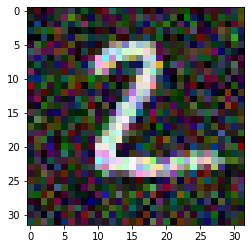

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s]


Adversarial image at step 32. L2 error 2875.3669978140056 and class label 8.


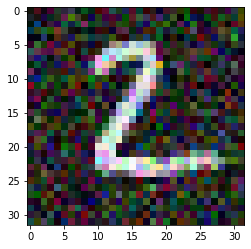

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.36it/s]


Adversarial image at step 33. L2 error 2850.8048348775833 and class label 8.


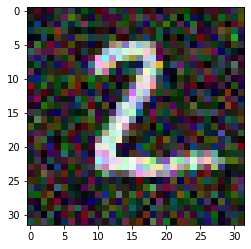

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s]


Adversarial image at step 34. L2 error 2821.566910640905 and class label 8.


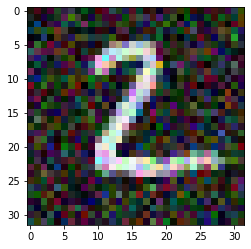

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Adversarial image at step 35. L2 error 2816.3238341042434 and class label 8.


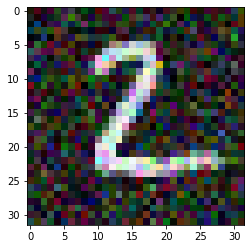

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 25.22it/s]


Adversarial image at step 36. L2 error 2803.490035531359 and class label 8.


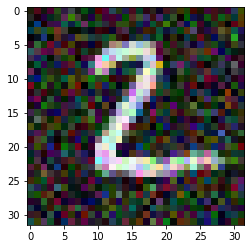

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


Adversarial image at step 37. L2 error 2782.5675498277324 and class label 8.


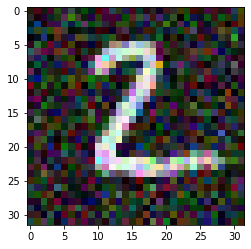

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.15it/s]


Adversarial image at step 38. L2 error 2755.6292012689523 and class label 8.


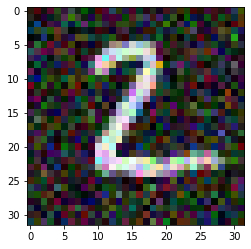

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.29it/s]


Adversarial image at step 39. L2 error 2734.2412692006233 and class label 8.


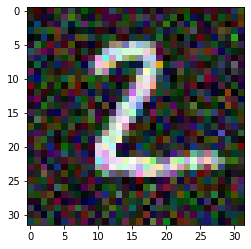

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.72it/s]


Adversarial image at step 40. L2 error 2702.485281208654 and class label 8.


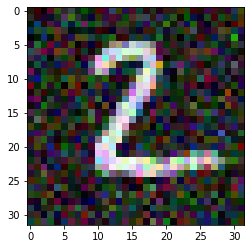

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]


Adversarial image at step 41. L2 error 2678.455308061587 and class label 8.


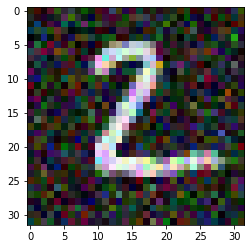

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.48it/s]


Adversarial image at step 42. L2 error 2649.992582553441 and class label 8.


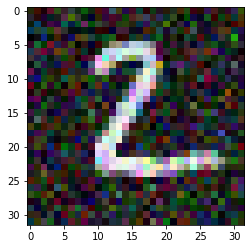

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 27.10it/s]

Adversarial image at step 43. L2 error 2630.890681916454 and class label 8.


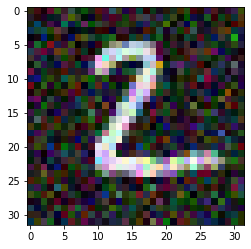

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 26.41it/s]


Adversarial image at step 44. L2 error 2603.088289594725 and class label 8.


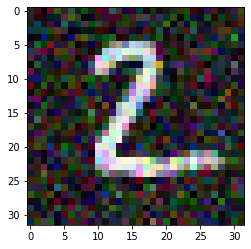

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.83it/s]


Adversarial image at step 45. L2 error 2585.0986043183843 and class label 8.


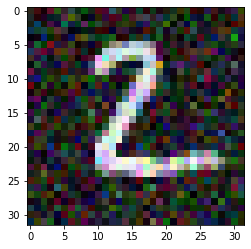

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.60it/s]


Adversarial image at step 46. L2 error 2571.761347610442 and class label 8.


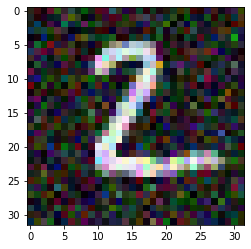

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s]


Adversarial image at step 47. L2 error 2558.472205845083 and class label 8.


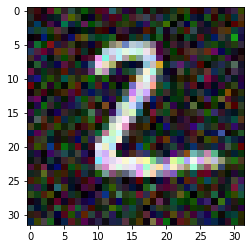

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 25.29it/s]


Adversarial image at step 48. L2 error 2548.1726003365516 and class label 8.


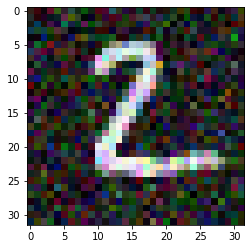

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]


Adversarial image at step 49. L2 error 2532.9071501943295 and class label 8.


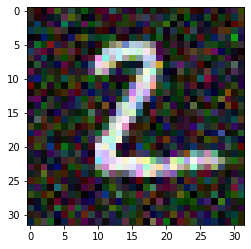

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.85it/s]


Adversarial image at step 50. L2 error 2525.09360469542 and class label 8.


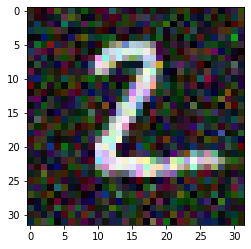

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


Adversarial image at step 51. L2 error 2519.588963580387 and class label 8.


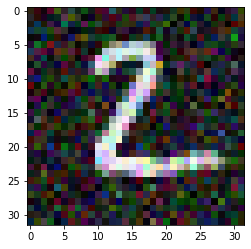

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 25.11it/s]


Adversarial image at step 52. L2 error 2505.456161571038 and class label 8.


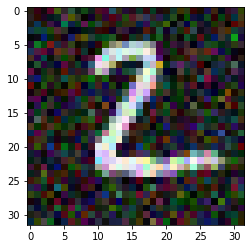

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


Adversarial image at step 53. L2 error 2488.059387458951 and class label 8.


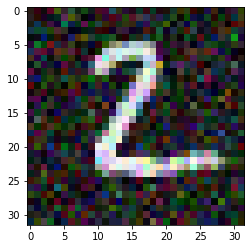

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


Adversarial image at step 54. L2 error 2460.0311722635233 and class label 8.


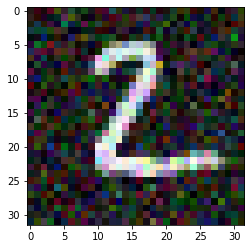

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


Adversarial image at step 55. L2 error 2431.8074002786475 and class label 8.


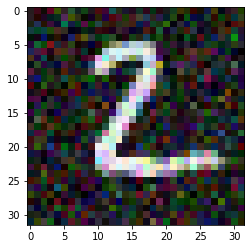

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.22it/s]


Adversarial image at step 56. L2 error 2404.0953933579685 and class label 8.


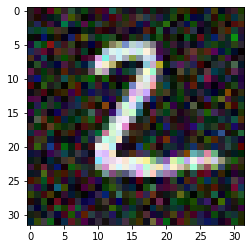

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.62it/s]


Adversarial image at step 57. L2 error 2389.7885921201787 and class label 8.


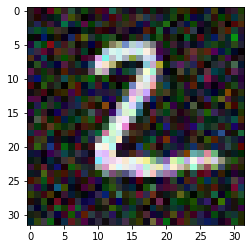

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Adversarial image at step 58. L2 error 2387.176204871148 and class label 8.


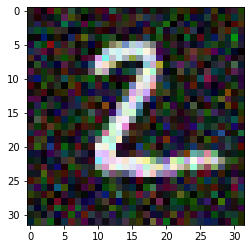

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 26.46it/s]


Adversarial image at step 59. L2 error 2380.138777442614 and class label 8.


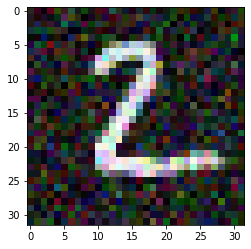

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.54it/s]


Adversarial image at step 60. L2 error 2375.308912924326 and class label 8.


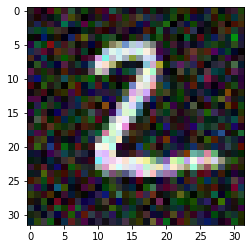

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.74it/s]


Adversarial image at step 61. L2 error 2366.7315269866203 and class label 8.


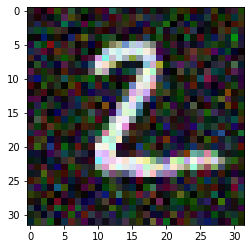

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.76it/s]


Adversarial image at step 62. L2 error 2359.3720650946557 and class label 8.


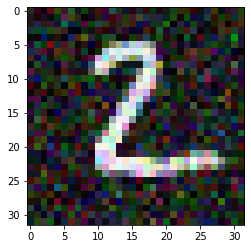

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


Adversarial image at step 63. L2 error 2352.4573872510823 and class label 8.


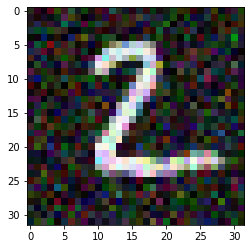

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.57it/s]


Adversarial image at step 64. L2 error 2341.793995162325 and class label 8.


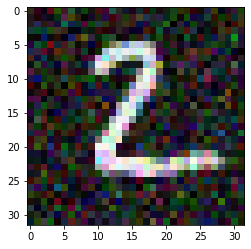

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


Adversarial image at step 65. L2 error 2331.323846497063 and class label 8.


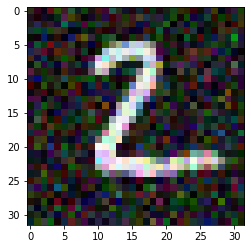

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


Adversarial image at step 66. L2 error 2328.6442882186348 and class label 8.


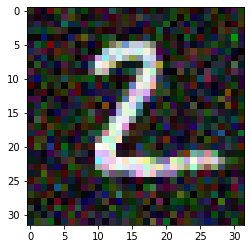

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.29it/s]


Adversarial image at step 67. L2 error 2325.593941837023 and class label 8.


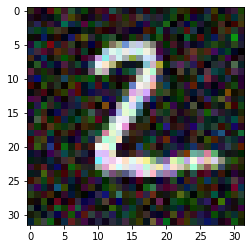

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s]


Adversarial image at step 68. L2 error 2321.778060728133 and class label 8.


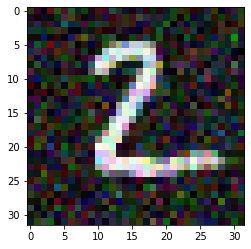

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 27.74it/s]


Adversarial image at step 69. L2 error 2320.544380525235 and class label 8.


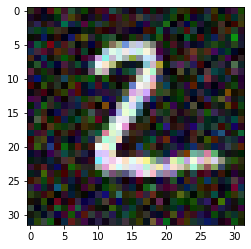

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s]


Adversarial image at step 70. L2 error 2315.2217125907 and class label 8.


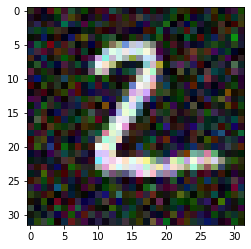

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s]


Adversarial image at step 71. L2 error 2307.626246569774 and class label 8.


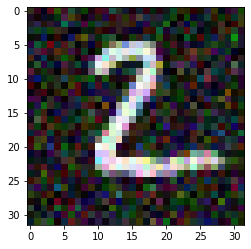

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.68it/s]


Adversarial image at step 72. L2 error 2294.93338538758 and class label 8.


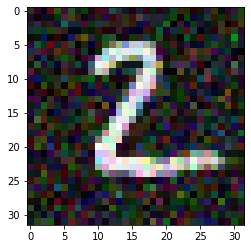

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s]


Adversarial image at step 73. L2 error 2288.338458101009 and class label 8.


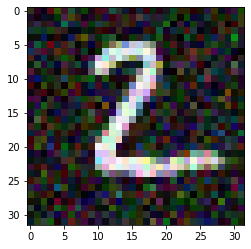

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.50it/s]


Adversarial image at step 74. L2 error 2281.075602124386 and class label 8.


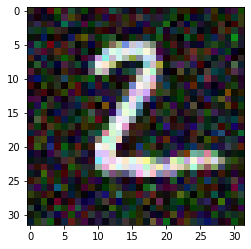

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.70it/s]


Adversarial image at step 75. L2 error 2273.6559714883992 and class label 8.


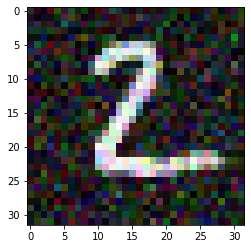

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.36it/s]


Adversarial image at step 76. L2 error 2274.360957279232 and class label 8.


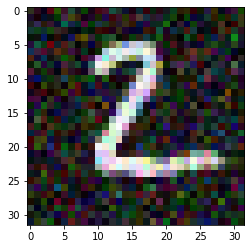

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.60it/s]


Adversarial image at step 77. L2 error 2273.4947201051464 and class label 8.


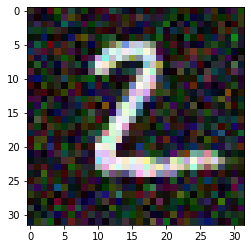

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


Adversarial image at step 78. L2 error 2269.307905424559 and class label 8.


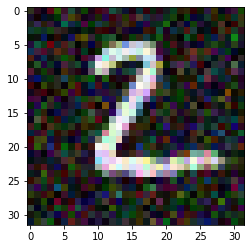

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.42it/s]


Adversarial image at step 79. L2 error 2263.7630545713364 and class label 8.


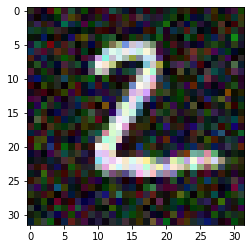

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]


Adversarial image at step 80. L2 error 2256.539562751925 and class label 8.


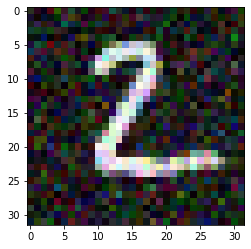

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s]


Adversarial image at step 81. L2 error 2248.5751043830905 and class label 8.


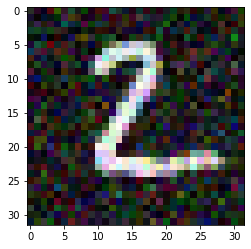

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.43it/s]


Adversarial image at step 82. L2 error 2239.0618129933946 and class label 8.


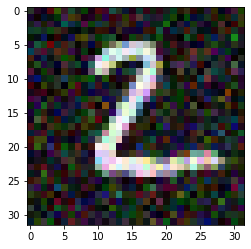

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 25.15it/s]


Adversarial image at step 83. L2 error 2230.5245934208456 and class label 8.


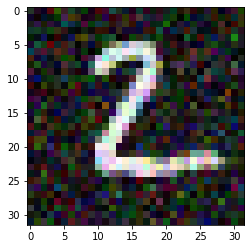

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]

Adversarial image at step 84. L2 error 2219.9248757804803 and class label 8.


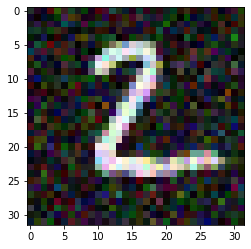

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.93it/s]


Adversarial image at step 85. L2 error 2203.4723224058725 and class label 8.


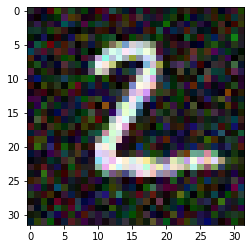

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.60it/s]


Adversarial image at step 86. L2 error 2183.2700576518446 and class label 8.


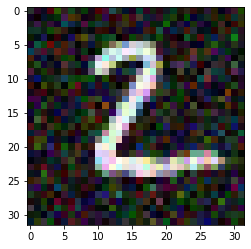

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


Adversarial image at step 87. L2 error 2168.8409487458925 and class label 8.


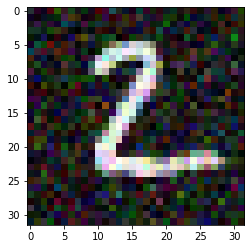

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 26.50it/s]


Adversarial image at step 88. L2 error 2154.718715008136 and class label 8.


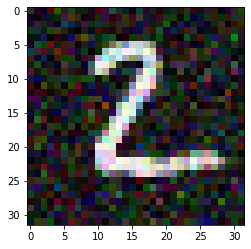

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


Adversarial image at step 89. L2 error 2148.218256698514 and class label 8.


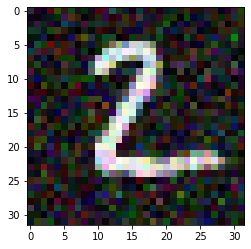

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.97it/s]


Adversarial image at step 90. L2 error 2143.240210727759 and class label 8.


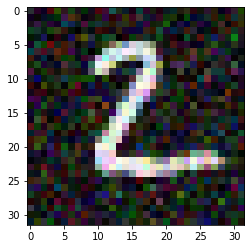

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.76it/s]


Adversarial image at step 91. L2 error 2137.9575502919974 and class label 8.


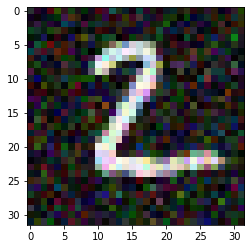

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.87it/s]


Adversarial image at step 92. L2 error 2133.8051127247127 and class label 8.


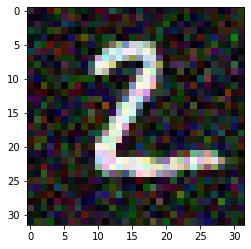

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


Adversarial image at step 93. L2 error 2129.0339599660965 and class label 8.


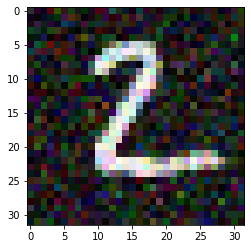

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s]


Adversarial image at step 94. L2 error 2124.8367600561132 and class label 8.


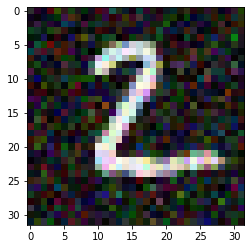

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


Adversarial image at step 95. L2 error 2122.34414215802 and class label 8.


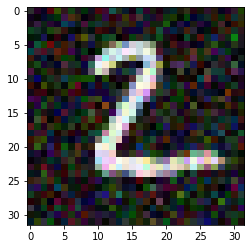

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 24.01it/s]


Adversarial image at step 96. L2 error 2117.2942960263276 and class label 8.


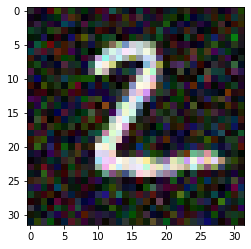

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 25.82it/s]


Adversarial image at step 97. L2 error 2109.4300035364754 and class label 8.


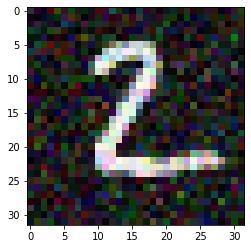

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


Adversarial image at step 98. L2 error 2103.258285198102 and class label 8.


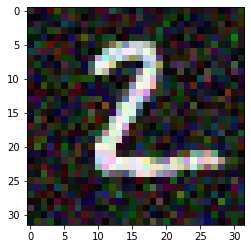

Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 21.65it/s]


Adversarial image at step 99. L2 error 2095.5161985873597 and class label 8.


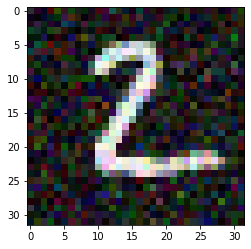

In [18]:
model_with_def=models_dict[0.9]

classifier = TensorFlowV2Classifier(model=model_with_def, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change_with_def={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.01)
iter_step =1
image_list=[]
target=X_test[1]
x_adv = None
for i in range(100):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype('int32'))
    image_list.append(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change_with_def[i * iter_step]=DOC([x_adv[0]],[target])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break


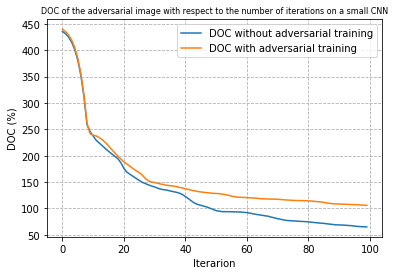

In [21]:
plt.plot(list(degree_of_change_without_def.keys()),list(degree_of_change_without_def.values()),label='DOC without adversarial training')
plt.plot(list(degree_of_change_with_def.keys()),list(degree_of_change_with_def.values()),label='DOC with adversarial training')
plt.grid(True,which="both", linestyle='--')
plt.title('DOC of the adversarial image with respect to the number of iterations on a small CNN', fontsize=8)
plt.xlabel('Iterarion')
plt.ylabel('DOC (%)')

plt.legend(loc='upper right')
plt.show()